# **Forecasting Consumer Price Index**

- The objective of this problem is to build a time series model that can forecast the consume price index (CPI) for the next 5 years.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
ps_cpi = pd.read_csv('Downloads/PriceStats_CPI.csv')

ps_cpi.head()

,date,PriceStats,CPI
0,24-07-2008,100.00000,100.0
1,25-07-2008,99.99767,100.0
2,26-07-2008,99.92376,100.0
3,27-07-2008,99.91537,100.0
4,28-07-2008,99.89491,100.0


**Observation:**

- We can see that while PriceStats changes daily, the CPI only changes monthly. Hence, the monthly CPI can be obtained by taking the CPI of any day during a month.

In [3]:
# Converting the date column into datetime format

ps_cpi['date'] = pd.to_datetime(ps_cpi['date'], infer_datetime_format = True)

ps_cpi.head()

,date,PriceStats,CPI
0,2008-07-24,100.00000,100.0
1,2008-07-25,99.99767,100.0
2,2008-07-26,99.92376,100.0
3,2008-07-27,99.91537,100.0
4,2008-07-28,99.89491,100.0


In [4]:
ps_cpi.shape

(3732, 3)

In [5]:
# Since CPI data changes monthly, creating Dataframe cpi_monthly
cpi_monthly = pd.DataFrame(columns = ['Month','CPI']) 

#Creating month column  
ps_cpi['YearMonth'] = ps_cpi['date'].dt.strftime('%Y - %m')

ps_cpi.head(5)

,date,PriceStats,CPI,YearMonth
0,2008-07-24,100.00000,100.0,2008 - 07
1,2008-07-25,99.99767,100.0,2008 - 07
2,2008-07-26,99.92376,100.0,2008 - 07
3,2008-07-27,99.91537,100.0,2008 - 07
4,2008-07-28,99.89491,100.0,2008 - 07


In [6]:
# Pulling data for cpi monthly values

cpi = ps_cpi.drop_duplicates('YearMonth', keep = 'last').copy().reset_index().drop(['index','PriceStats'], axis = 1) 

cpi.head(5)

,date,CPI,YearMonth
0,2008-07-31,100.00000,2008 - 07
1,2008-08-31,100.52510,2008 - 08
2,2008-09-30,100.12380,2008 - 09
3,2008-10-31,99.98538,2008 - 10
4,2008-11-30,98.97539,2008 - 11


In [7]:
# Splitting the data into train and test sets

cpi_train = (cpi[cpi.YearMonth < '2013-09'].copy()) 

cpi_test = (cpi[cpi.YearMonth >= '2013-09'].copy()) 

cpi.shape, cpi_train.shape, cpi_test.shape

((115, 3), (66, 3), (48, 3))

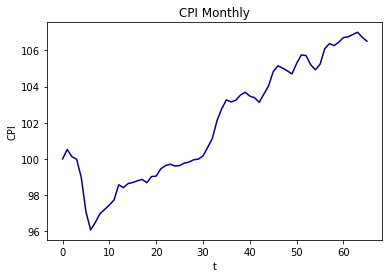

In [8]:
# Let's visualize the time series for training dataset

plt.plot(cpi_train.index, cpi_train.CPI, color = 'navy')

plt.xlabel('t')

plt.ylabel('CPI')

plt.title('CPI Monthly')

plt.show()

**From the visualization above, it is clear that the time series has a deterministic trend. We will try and fit a linear model to the data and see if that is sufficient to represent the trend. We then subtract this trend from the data.**

The linear trend is given by F(t) = 0.16009489280868378*t + (96.74978204432384)


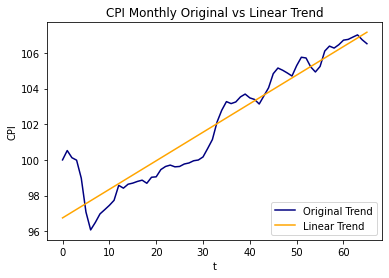

In [9]:
# fitting a linear model on the training data.

from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(np.array(cpi_train.index).reshape(-1, 1), cpi_train.CPI) 

coefficients = [model.coef_[0], model.intercept_] 

print("The linear trend is given by F(t) = " +str(coefficients[0]) + "*t + (" +str (coefficients[1]) + ")") 

linear_cpi = model.predict(np.array(cpi_train.index).reshape(-1, 1)) 

plt.plot(cpi_train.index, cpi_train.CPI, color = 'navy', label = 'Original Trend')

plt.xlabel('t')

plt.ylabel('CPI')

plt.title('CPI Monthly Original vs Linear Trend')

plt.plot(cpi_train.index, linear_cpi, color = 'orange', label = 'Linear Trend')

plt.legend(loc = 'lower right')

plt.show()

In [10]:
# Input method for detrended the data. Type 'linear' if we want to detrend by substracting the linear model

x = input('Choose Method:')

Choose Method:linear


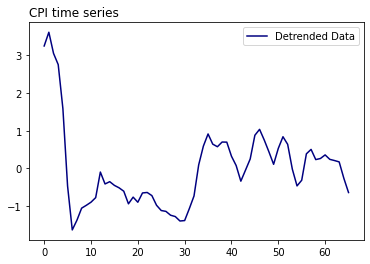

In [11]:
if x == 'linear': 
    
    remaining = cpi_train.CPI - linear_cpi 

    linear_cpi_test = model.predict(np.array(cpi_test.index).reshape(-1, 1))  

    remaining_test = cpi_test.CPI - linear_cpi_test 

    test = cpi_test.index 

    train = cpi_train.index

else: 
    cpi_diff = np.log(cpi.CPI).diff() 

    remaining = cpi_diff[0 : cpi_train.shape[0]] 

    remaining.iloc[0] = 0  

    remaining_test = cpi_diff[cpi_train.shape[0]:].dropna() 

    remaining_test.iloc[0] = 0 

    test = cpi_test.index 

    train = cpi_train.index 

plt.plot(train, remaining, color = "navy", label = 'Detrended Data') 

plt.title('CPI time series', loc = 'left')

plt.legend(loc = 'upper right')

plt.show()

**Observation:**

- As observed above, there seems to be no other trend present in the residual after subtracting the linear model, as the time series has a horizontal orientation on xy-plane. 
- The time series has been detrended

In [12]:
# Note, we will be required to add the trend back later to get forcast result.

# function to add the trend back

def rebuild_diffed(series, first_element_original, x, linear_trend):  
    if x == 'linear': 
        final = series + linear_trend 
    
    else: 
        cumsum = pd.Series(series).cumsum() 

        final = np.exp(cumsum.fillna(0) + first_element_original)
    
        if first_element_original == 0: 
            final = np.exp(cumsum.fillna(0)) 
    
    return final


**Deseasonalize Data**

- After detrending time series, next step should be to deseasonalize the data. However, since there is no clear seasonality in the detrended time series, we directly proceed to fit an AR Model on the residual.

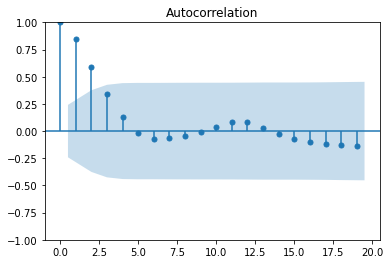

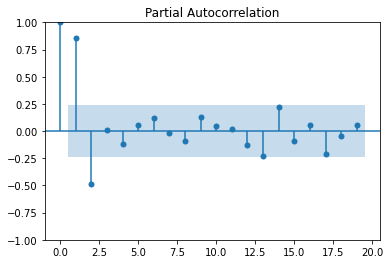

In [13]:
# We first plot the autocorrelation and partial autocorrelation plots.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(remaining) 

plt.show() 

plot_pacf(remaining)

plt.show()

**Observation:**

- From the above PACF plot, we can see that the highest lag at which the plot extends beyond the statistically significant boundary is at lag 2. This indicates that an AR Model of lag 2 should be sufficient to fit the data. 

Test RMSE for AR(1):0.39539329778393806
Test RMSE for AR(2):0.4213968147033323
Test RMSE for AR(3):0.4052614560873425
Test RMSE for AR(4):0.4746821646771566
Test RMSE for AR(5):0.4596989307247363


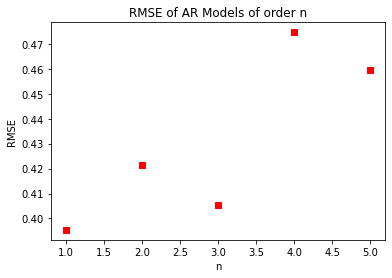

In [14]:
# Verifying rmse of our AR model at different lags

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error


rmse_ar = []

for n in range(1, 6):
    model = AutoReg(remaining, lags = n)
    
    model_fit = model.fit()
    
    coef = model_fit.params
    
    past = remaining[len(remaining) - n:].values
    
    past = [past[i] for i in range(len(past))]
    
    test_predictions = list()
    
    for t in range(len(remaining_test)): 
        length = len(past)
        
        lag = [past[i] for i in range(length - n, length)]
        
        pred = coef[0]
        
        for d in range(n):
            
            pred += coef[d+1] * lag[n - d - 1]
            
        obs = remaining_test.values[t]
        
        test_predictions.append(pred)
        
        past.append(obs)
        
    rmse = (mean_squared_error(remaining_test, test_predictions)) ** 0.5
    
    rmse_ar.append(rmse)
    
    print('Test RMSE for AR(' + str(n) +'):' + str(rmse))

plt.scatter(np.arange(1,6), rmse_ar,marker = "s", color = 'red')

plt.xlabel("n")

plt.ylabel("RMSE")

plt.title("RMSE of AR Models of order n")

plt.show()

**Observation:**

- The plot above seems to indicate the AR(1) model predictions have the least rmse but we will work with the AR model order of 2 so we do not miss out on possible lag terms.

In [15]:
## Building the AR(2) Model
n = 2

AR2_model = AutoReg(remaining, lags = n).fit()

coef = AR2_model.params

# Walk forward over time steps in test
past = remaining[len(remaining)-n:].values

past = [past[i] for i in range(len(past))]

test_predictions = list()

training_predictions = AR2_model.predict(start = train[0], end = train[-1])

for t in range(len(remaining_test)):
    length = len(past)
    
    lag = [past[i] for i in range(length - n , length)]
    
    pred = coef[0]
    
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
        
    obs = remaining_test.values[t]
    
    test_predictions.append(pred)
    
    past.append(obs)
    
final_training = (rebuild_diffed(training_predictions, np.log(cpi_train.CPI[0]), x, linear_cpi))

final_test = (rebuild_diffed(test_predictions, np.log(cpi_train.iloc[-1].CPI), x, linear_cpi_test))

Text(0.5, 1.0, 'CPI predictions')

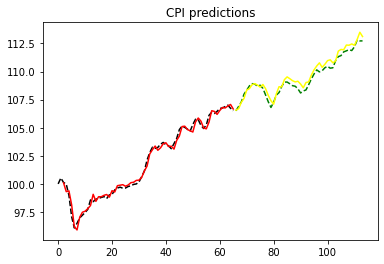

In [16]:
# plotting the final model predictions and the actual observed data together to visualize the fit.

plt.plot(cpi_train.index, cpi_train.CPI, color = 'black', linestyle = 'dashed', label = 'Training')

plt.plot(cpi_test.index, cpi_test.CPI, color = 'green', linestyle = 'dashed', label = 'Test')

plt.plot(cpi_train.index, final_training, color = 'red', label = 'Final AF')

plt.plot(cpi_test.index, final_test, color = 'yellow', label = 'Final AF')

plt.title("CPI predictions")

**Observation:**

- The AR(2) Model does predict pretty well as we can see the original and predicted data are very close. 

In [17]:
# Evaluating the error on the model

rmse = mean_squared_error(cpi_test.CPI,final_test) ** 0.5
print("The rmse of the final fit is " + str(rmse))

The rmse of the final fit is 0.42139681470333185


**Observation:**

- The root mean squared prediction error is small.